In [1]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
from mlx.data.datasets import load_mnist

In [2]:
# Load MNIST dataset
# If not exists, the mlx.data package will download
# the dataset into your local directory
# you can provide `root` arguments to set the destination
mnist_train = load_mnist(train=True)
mnist_test = load_mnist(train=False)

len(mnist_train), len(mnist_test)

(60000, 10000)

In [3]:
def get_streamed_data(data, batch_size=0, shuffled=True):
    buffer = data.shuffle() if shuffled else data
    stream = buffer.to_stream()
    stream = stream.key_transform("image", lambda x: x.astype("float32").reshape(-1,))
    stream = stream.batch(batch_size) if batch_size > 0 else stream
    return stream.prefetch(4, 2)

mnist_trainstream = get_streamed_data(mnist_train)

## Without .reshape(-1,), the shape of the batch is (n, 28, 28, 1)
## With .reshape(-1,) the shape of the batch is (n, 784) -> easier to handle with fully-connected layer

# Uncomment below lines to see the shape
first_batch = next(mnist_trainstream)
X, y = first_batch["image"], first_batch["label"]
X.shape, y.shape

((784,), ())

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dims=input_dims, output_dims=hidden_dims),
            nn.ReLU(),
            nn.Linear(input_dims=hidden_dims, output_dims=hidden_dims),
            nn.ReLU(),
            nn.Linear(input_dims=hidden_dims, output_dims=hidden_dims),
            nn.ReLU(),
            nn.Linear(input_dims=hidden_dims, output_dims=output_dims)
        )
    def __call__(self, x):
        return self.sequential(x)

model = MLP(input_dims=784, hidden_dims=64, output_dims=10)
mx.eval(model.parameters())
model

MLP(
  (sequential): Sequential(
    (layers.0): Linear(input_dims=784, output_dims=64, bias=True)
    (layers.1): ReLU()
    (layers.2): Linear(input_dims=64, output_dims=64, bias=True)
    (layers.3): ReLU()
    (layers.4): Linear(input_dims=64, output_dims=64, bias=True)
    (layers.5): ReLU()
    (layers.6): Linear(input_dims=64, output_dims=10, bias=True)
  )
)

In [5]:
def loss_fn(model, X, y):
    logits = model(X)
    return nn.losses.cross_entropy(logits, y, reduction="mean")

def eval_fn(model, X, y):
    logits = model(X)
    pred = nn.softmax(logits)
    return mx.mean(mx.argmax(pred, axis=1) == y)


In [6]:
# Start training loop

epochs = 50
loss_and_grad_fn = nn.value_and_grad(model, loss_fn)


optimizer = optim.SGD(learning_rate=0.01)
for epoch in range(epochs):
    epoch_loss = 0.0
    train_acc = 0.0
    epoch_counter = 0
    for batch in get_streamed_data(mnist_train, batch_size=256):
        X, y = batch["image"], batch["label"]
        # Need to convert X and y into mlx.core.array type
        X, y = mx.array(X), mx.array(y)
        # Compute loss and its gradient with respect to the model's trainable parameters
        loss, grad = loss_and_grad_fn(model, X, y)
        # Step the optimizer
        optimizer.update(model, grad)
        # Evaluate computational graph
        mx.eval(model.parameters(), optimizer.state)
        epoch_loss += loss.item()
        epoch_counter += 1
        train_acc += eval_fn(model, X, y).item()
    epoch_loss /= epoch_counter
    train_acc /= epoch_counter

    test_acc_counter = 0.0
    test_acc = 0.0
    for batch in get_streamed_data(mnist_test, batch_size=32, shuffled=False):
        X, y = batch["image"], batch["label"]
        X, y = mx.array(X), mx.array(y)
        acc = eval_fn(model, X, y)
        test_acc += acc.item()
        test_acc_counter += 1
    test_acc /= test_acc_counter
    print(f"Epoch: {epoch} | Train Loss: {epoch_loss}, Train Accuracy: {train_acc} | Test Accuracy: {test_acc}")
        

Epoch: 0 | Train Loss: 0.45997126501495555, Train Accuracy: 0.8929889959804083 | Test Accuracy: 0.8486567579519254
Epoch: 1 | Train Loss: 0.19658319265284438, Train Accuracy: 0.9647955820915547 | Test Accuracy: 0.9472843450479234
Epoch: 2 | Train Loss: 0.15365563917084266, Train Accuracy: 0.9763999904616404 | Test Accuracy: 0.9420926517571885
Epoch: 3 | Train Loss: 0.1275998764371468, Train Accuracy: 0.9809565670409445 | Test Accuracy: 0.8394568690095847
Epoch: 4 | Train Loss: 0.11648301098503615, Train Accuracy: 0.9849780835842682 | Test Accuracy: 0.9364017571884984
Epoch: 5 | Train Loss: 0.09625106829595058, Train Accuracy: 0.9879709664811479 | Test Accuracy: 0.9624600638977636
Epoch: 6 | Train Loss: 0.08537978987268945, Train Accuracy: 0.9897938829787234 | Test Accuracy: 0.9615615015974441
Epoch: 7 | Train Loss: 0.07671415671643059, Train Accuracy: 0.9916909427966102 | Test Accuracy: 0.9472843450479234
Epoch: 8 | Train Loss: 0.07125662799956183, Train Accuracy: 0.9926926640130705 | 

In [7]:
# Testing out with one random sample
test_stream = get_streamed_data(mnist_test, batch_size=1)
test_batch = next(test_stream)
X, y = mx.array(test_batch["image"]), mx.array(test_batch["label"])

# See how the model produce logits
logits = model(X)
print(f"Logits: {logits}")

# See we can compute the softmax from the logits
softmax = nn.softmax(logits)
print(f"Softmax-ed: {softmax}")

# Get predicted label and true label
predicted_label = mx.argmax(softmax, axis=1).item()
confidence_level = mx.max(softmax, axis=1).item()
print(f"Predicted label: {predicted_label}, True label: {y.item()} | Confidence level: {confidence_level}")

Logits: array([[-14.2469, -1.9668, -11.8256, ..., -1.17542, 6.20511, -0.116776]], dtype=float32)
Softmax-ed: array([[2.21079e-20, 4.76115e-15, 2.48945e-19, ..., 1.05052e-14, 1.6855e-11, 3.02808e-14]], dtype=float32)
Predicted label: 5, True label: 5 | Confidence level: 1.0


In [8]:
# get precision, recall, and f1-score
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

y_true = []
y_pred = []
for batch in get_streamed_data(mnist_test, batch_size=32, shuffled=False):
    X, y = batch["image"], batch["label"]
    X, y = mx.array(X), mx.array(y)
    logits = model(X)
    prediction = mx.argmax(mx.softmax(logits), axis=1)
    y_true = y_true + y.tolist()
    y_pred = y_pred + prediction.tolist()
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")
print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

Precision: 0.9575220002943606
Recall: 0.9569
F1 Score: 0.9569227123077513


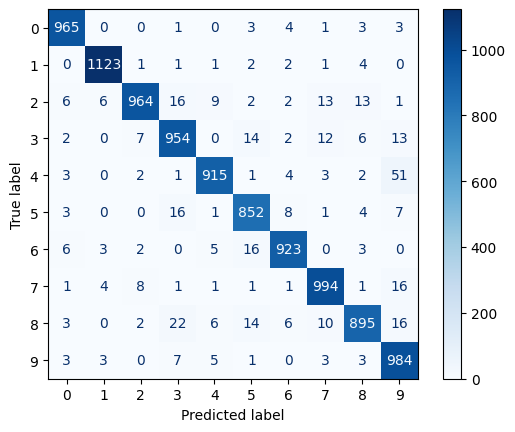

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(conf_matrix)
display.plot(cmap=plt.cm.Blues)
plt.show()